# Goals

### 1. Learn to implement Resnext Block (Type - 2) using monk
    - Monk's Keras
    - Monk's Pytorch
    - Monk's Mxnet
    
### 2. Use network Monk's debugger to create complex blocks 


### 3. Understand how syntactically different it is to implement the same using
    - Traditional Keras
    - Traditional Pytorch
    - Traditional Mxnet

# Resnext Block - Type 2
 
 - Note: The block structure can have variations too, this is just an example

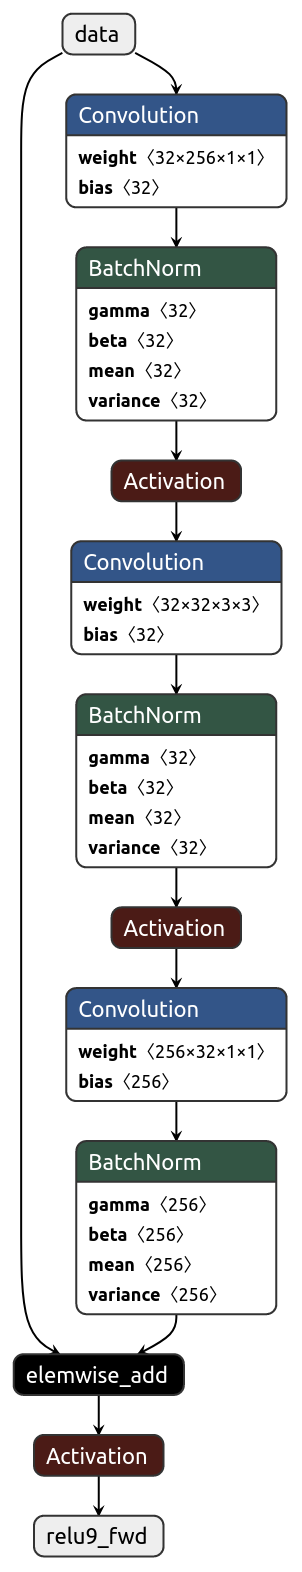

In [7]:
from IPython.display import Image
Image(filename='imgs/resnext_without_downsample.png')

# Table of contents

[1. Install Monk](#1)


[2. Block basic Information](#2)

  - [2.1) Visual structure](#2-1)
  
  - [2.2) Layers in Branches](#2-2)


[3) Creating Block using monk visual debugger](#3)

  - [3.1) Create the first branch](#3-1)

  - [3.2) Create the second branch](#3-2)
  
  - [3.3) Merge the branches](#3-3)
  
  - [3.4) Debug the merged network](#3-4)
  
  - [3.5) Compile the network](#3-5)
  
  - [3.6) Visualize the network](#3-6)
  
  - [3.7) Run data through the network](#3-7)
  
  
[4) Creating Block Using MONK one line API call](#4)

  - [Mxnet Backend](#4-1)
  
  - [Pytorch Backend](#4-2)
  
  - [Keras Backend](#4-3)
  
  
  
[5) Appendix](#5)

  - [Study Material](#5-1)
  
  - [Creating block using traditional Mxnet](#5-2)
  
  - [Creating block using traditional Pytorch](#5-3)
  
  - [Creating block using traditional Keras](#5-4)
    

<a id='1'></a>
# Install Monk
  
 - git clone https://github.com/Tessellate-Imaging/monk_v1.git
 
 - cd monk_v1/installation/Linux && pip install -r requirements_cu9.txt
     - (Select the requirements file as per OS and CUDA version)

In [ ]:
!git clone https://github.com/Tessellate-Imaging/monk_v1.git

# Imports

In [1]:
# Common
import numpy as np
import math
import netron
from collections import OrderedDict
from functools import partial

In [2]:
# Monk
import os
import sys
sys.path.append("monk_v1/monk/");

<a id='2'></a>
# Block Information

<a id='2_1'></a>
## Visual structure

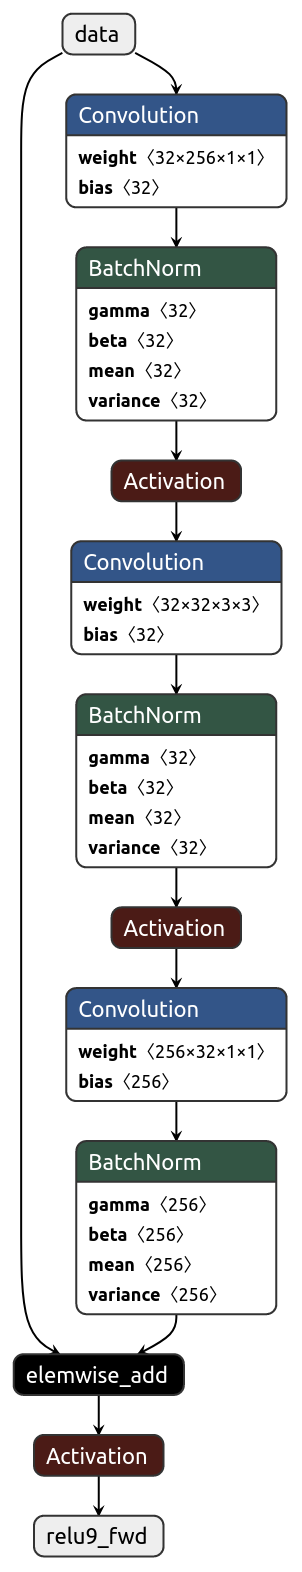

In [8]:
from IPython.display import Image
Image(filename='imgs/resnext_without_downsample.png')

<a id='2_2'></a>
## Layers in Branches

  - Number of branches: 2
  
  
  - Branch 1
    - identity
  
  
  - Branch 2
    - conv_1x1 -> batchnorm -> relu -> conv_3x3 -> batchnorm -> relu -> conv_1x1 -> batchnorm
    
    
  - Branches merged using
    - Elementwise addition
    
    
(See Appendix to read blogs on resnexts)

<a id='3'></a>
# Creating Block using monk debugger

In [9]:
# Imports and setup a project
# To use pytorch backend - replace gluon_prototype with pytorch_prototype
# To use keras backend - replace gluon_prototype with keras_prototype

from gluon_prototype import prototype

# Create a sample project
gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");

Mxnet Version: 1.5.1

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/



<a id='3-1'></a>
## Create the first branch

In [10]:
def first_branch():
    network = [];
    network.append(gtf.identity());
    return network;

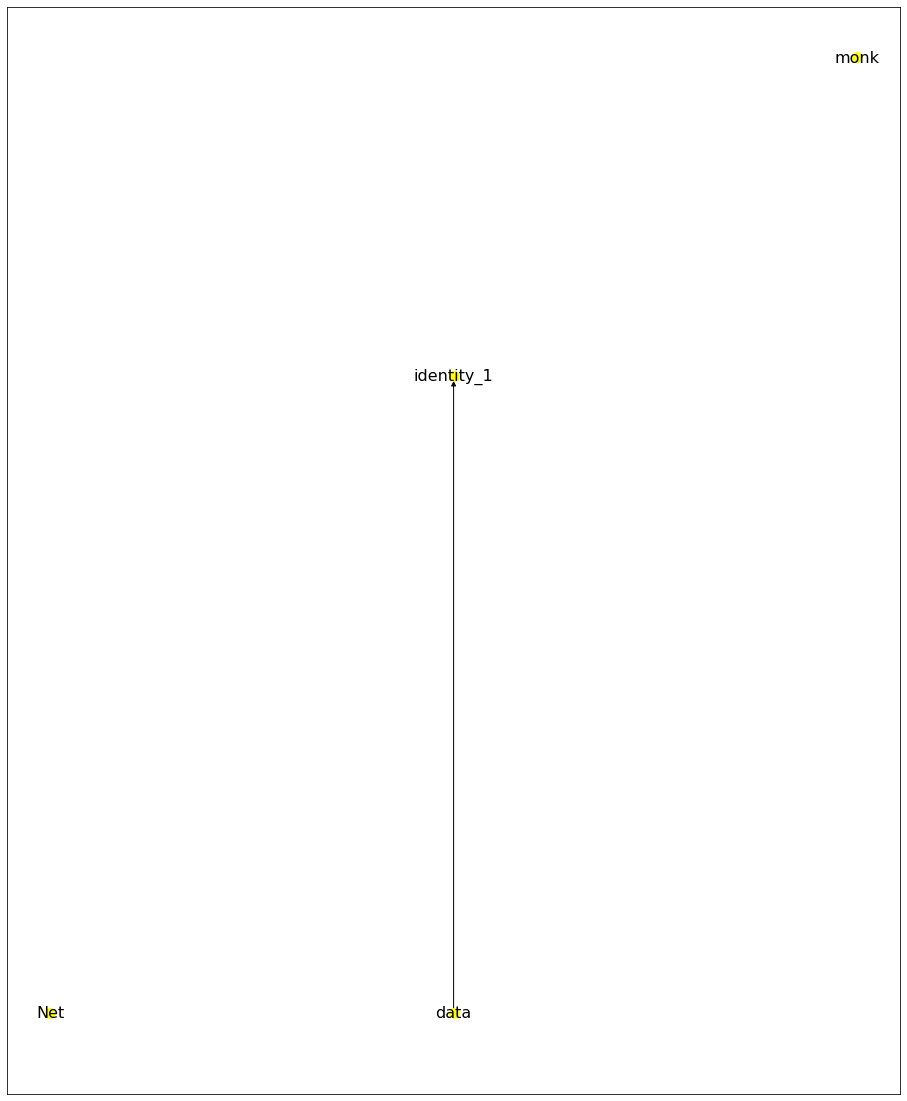

In [11]:
# Debug the branch
branch_1 = first_branch()
network = [];
network.append(branch_1);
gtf.debug_custom_model_design(network);

<a id='3-2'></a>
## Create the second branch

In [12]:
def second_branch(output_channels=256, cardinality=8, bottleneck_width=4, stride=1):
    network = [];
    
    channels = output_channels//4;
    D = int(math.floor(channels * (bottleneck_width / 64)))
    group_width = cardinality * D
    
    network.append(gtf.convolution(output_channels=group_width, kernel_size=1, stride=1));
    network.append(gtf.batch_normalization());
    network.append(gtf.relu());
    network.append(gtf.convolution(output_channels=group_width, kernel_size=3, stride=stride));
    network.append(gtf.batch_normalization());
    network.append(gtf.relu());
    network.append(gtf.convolution(output_channels=output_channels, kernel_size=1, stride=1));
    network.append(gtf.batch_normalization());
    return network;

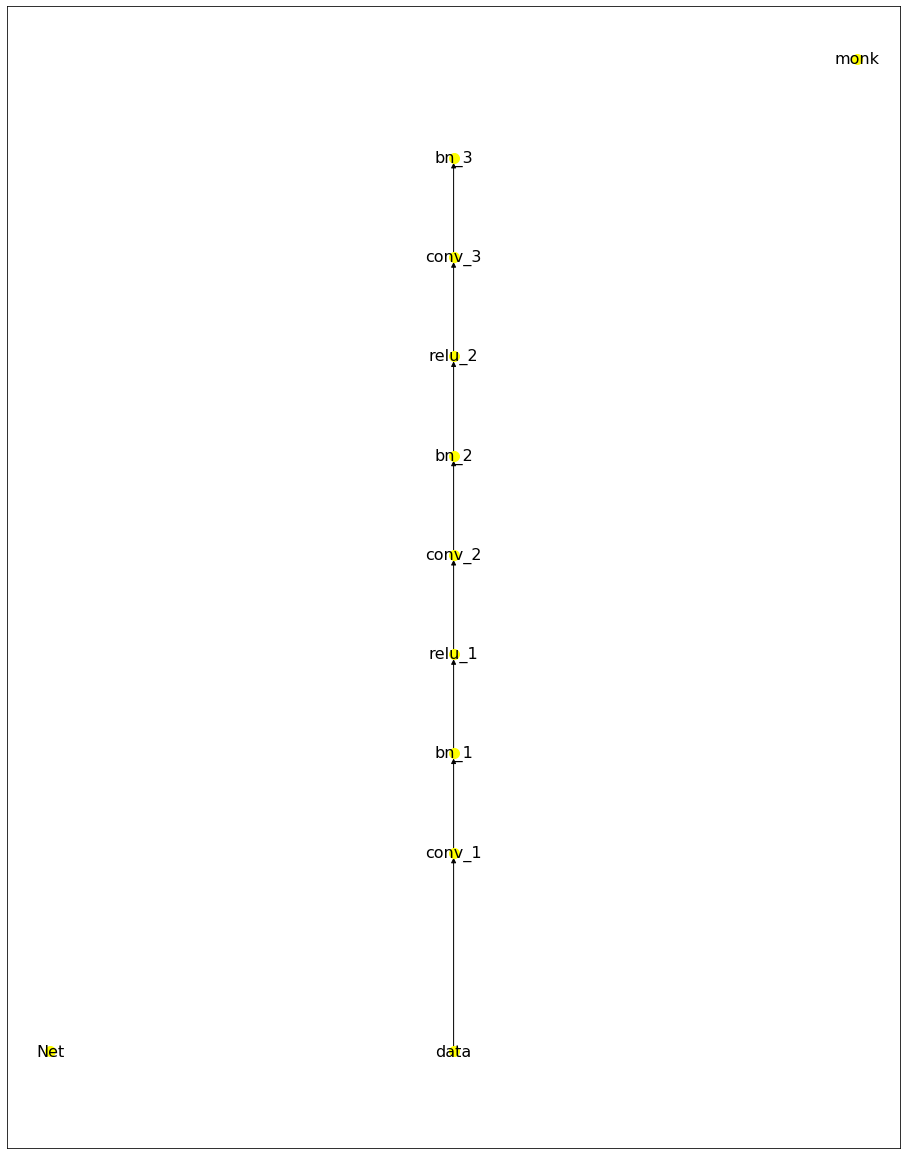

In [13]:
# Debug the branch
branch_2 = second_branch(output_channels=256, cardinality=8, bottleneck_width=4, stride=1)
network = [];
network.append(branch_2);
gtf.debug_custom_model_design(network);

<a id='3-3'></a>
## Merge the branches

In [14]:
def final_block(output_channels=256, cardinality=8, bottleneck_width=4, stride=1):
    network = [];
    
    #Create subnetwork and add branches
    subnetwork = [];
    branch_1 = first_branch()
    branch_2 = second_branch(output_channels=output_channels, 
                             cardinality=cardinality, 
                             bottleneck_width=bottleneck_width, 
                             stride=stride)
    subnetwork.append(branch_1);
    subnetwork.append(branch_2);
    
    # Add merging element
    subnetwork.append(gtf.add());
    
    # Add the subnetwork
    network.append(subnetwork)
    network.append(gtf.relu());
    return network;

<a id='3-4'></a>
## Debug the merged network

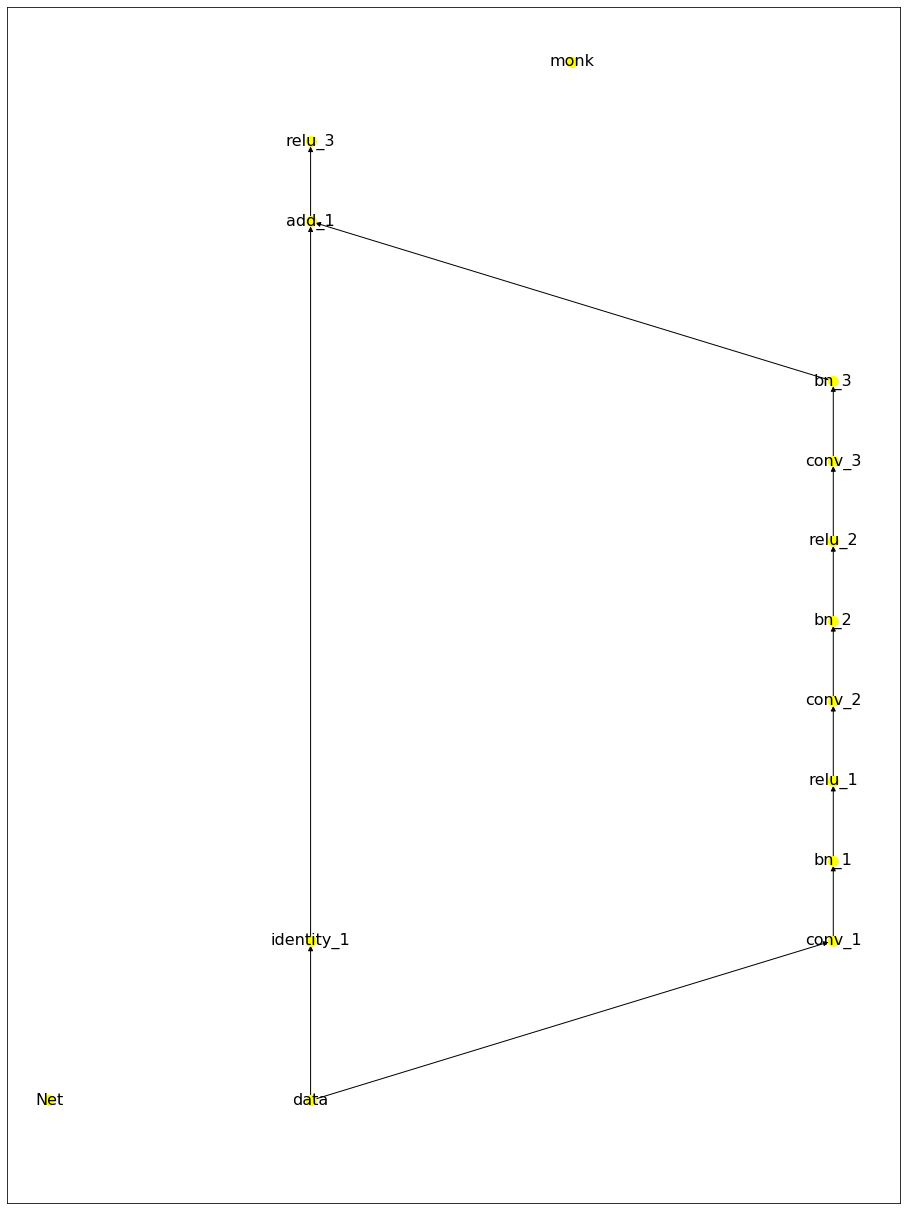

In [15]:
final = final_block(output_channels=256, stride=1)
network = [];
network.append(final);
gtf.debug_custom_model_design(network);

<a id='3-5'></a>
## Compile the network

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num of potentially trainable layers:  6
        Num of actual trainable layers:       6



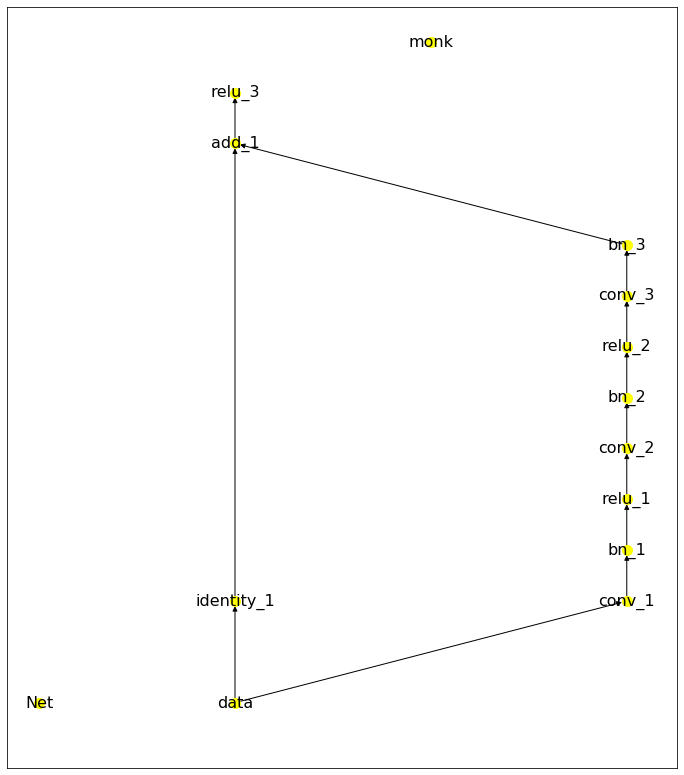

In [16]:
gtf.Compile_Network(network, data_shape=(256, 224, 224), use_gpu=False);

<a id='3-6'></a>
## Run data through the network

In [17]:
import mxnet as mx
x = np.zeros((1, 256, 224, 224));
x = mx.nd.array(x);
y = gtf.system_dict["local"]["model"].forward(x);
print(x.shape, y.shape)

(1, 256, 224, 224) (1, 256, 224, 224)


<a id='3-7'></a>
## Visualize network using netron

In [18]:
gtf.Visualize_With_Netron(data_shape=(256, 224, 224))

Using Netron To Visualize
Not compatible on kaggle
Compatible only for Jupyter Notebooks

Stopping http://localhost:8080
Serving 'model-symbol.json' at http://localhost:8080


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 54994)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 654, in process_request_thread
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/home/abhi/.virtualenvs/finetune_py36/lib/python3.6/site-packages/netron/server.py", line 106, in do_GET
    self.handler()
  File "/home/abhi/.virtualenvs/finetune_py36/lib/python3.6/site-packages/netron/server.py", line 103, in handler
    self.wfile.write(buffer)
  File "/usr/lib/python3.6/socketserver.py",

<a id='4'></a>
# Creating Using MONK LOW code API

<a id='4-1'></a>
## Mxnet backend

Mxnet Version: 1.5.1

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num of potentially trainable layers:  6
        Num of actual trainable layers:       6



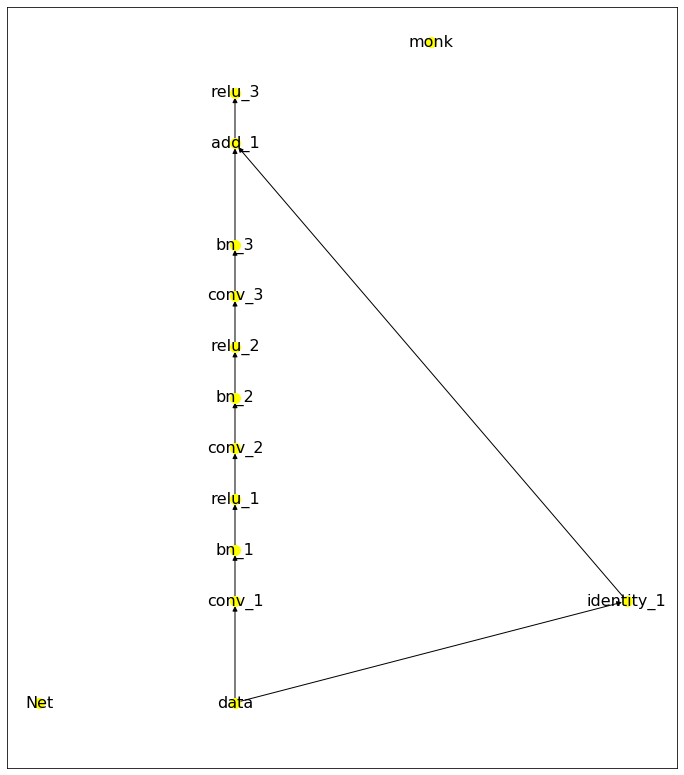

In [4]:
from gluon_prototype import prototype
gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");


network = [];

# Single line addition of blocks
network.append(gtf.resnext_block(output_channels=256, cardinality=8, bottleneck_width=4, downsample=False));


gtf.Compile_Network(network, data_shape=(256, 224, 224), use_gpu=False);


<a id='4-2'></a>
## Pytorch backend

  - Only the import changes

Pytorch Version: 1.2.0

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num layers in model:  6
        Num trainable layers: 6



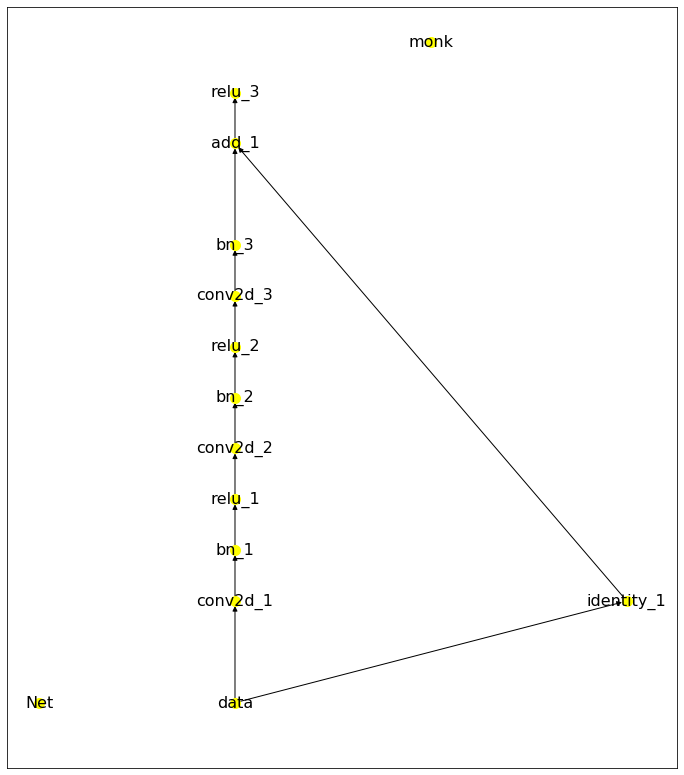

In [19]:
#Change gluon_prototype to pytorch_prototype
from pytorch_prototype import prototype


gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");


network = [];

# Single line addition of blocks
network.append(gtf.resnext_block(output_channels=256, cardinality=8, 
                                 bottleneck_width=4, downsample=False));


gtf.Compile_Network(network, data_shape=(256, 224, 224), use_gpu=False);

<a id='4-3'></a>
## Keras backend

  - Only the import changes

Keras Version: 2.2.5
Tensorflow Version: 1.12.0

Experiment Details
    Project: sample-project-1
    Experiment: sample-experiment-1
    Dir: /home/abhi/Desktop/Work/tess_tool/gui/v0.3/finetune_models/Organization/development/v5.0_blocks/study_roadmap/blocks/workspace/sample-project-1/sample-experiment-1/

Model Details
    Loading pretrained model
    Model Loaded on device
        Model name:                           Custom Model
        Num layers in model:  11
        Num trainable layers: 10



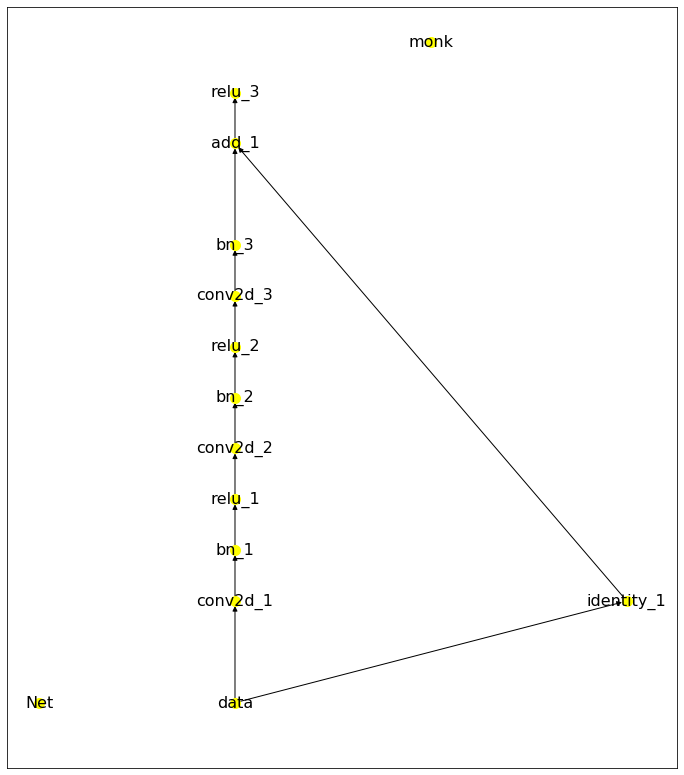

In [20]:
#Change gluon_prototype to keras_prototype
from keras_prototype import prototype


gtf = prototype(verbose=1);
gtf.Prototype("sample-project-1", "sample-experiment-1");


network = [];

# Single line addition of blocks
network.append(gtf.resnext_block(output_channels=256, cardinality=8, 
                                 bottleneck_width=4, downsample=False));


gtf.Compile_Network(network, data_shape=(256, 224, 224), use_gpu=False);

<a id='5'></a>
# Appendix

<a id='5-1'></a>
## Study links
  - https://towardsdatascience.com/review-resnext-1st-runner-up-of-ilsvrc-2016-image-classification-15d7f17b42ac
  - https://datascience.stackexchange.com/questions/47559/cardinality-vs-width-in-the-resnext-architecture
  - https://arxiv.org/abs/1611.05431
  - https://research.fb.com/downloads/resnext/

<a id='5-2'></a>
## Creating block using traditional Mxnet

 - Code credits - https://mxnet.incubator.apache.org/

In [21]:
# Traditional-Mxnet-gluon
import mxnet as mx
from mxnet.gluon import nn
from mxnet.gluon.nn import HybridBlock, BatchNorm
from mxnet.gluon.contrib.nn import HybridConcurrent, Identity
from mxnet import gluon, init, nd

In [22]:

def _conv3x3(channels, stride, in_channels):
    return nn.Conv2D(channels, kernel_size=3, strides=stride, padding=1,
                     use_bias=False, in_channels=in_channels)

class ResnextBlock(HybridBlock):
    def __init__(self, output_channels, stride, cardinality=8, bottleneck_width=4, in_channels=0, **kwargs):
        super(ResnextBlock, self).__init__(**kwargs)
        
        channels = output_channels//4;
        D = int(math.floor(channels * (bottleneck_width / 64)))
        group_width = cardinality * D
        
        #Branch - 1
        #IDentity
        
        
        # Branch - 2
        self.body = nn.HybridSequential(prefix='')
        self.body.add(nn.Conv2D(group_width, kernel_size=1, strides=1,
                                          use_bias=False, in_channels=in_channels))
        self.body.add(nn.BatchNorm())
        self.body.add(nn.Activation('relu'))
        self.body.add(_conv3x3(group_width, stride, in_channels))
        self.body.add(nn.BatchNorm())
        self.body.add(nn.Activation('relu'))
        self.body.add(nn.Conv2D(output_channels, kernel_size=1, strides=1,
                                          use_bias=False, in_channels=in_channels))
        self.body.add(nn.BatchNorm())
        

    def hybrid_forward(self, F, x):
        residual = x
        x = self.body(x)
        x = F.Activation(residual+x, act_type='relu')
        return x

In [23]:
# Invoke the block
block = ResnextBlock(256, 1)

# Initialize network and load block on machine
ctx = [mx.cpu()];
block.initialize(init.Xavier(), ctx = ctx);
block.collect_params().reset_ctx(ctx)
block.hybridize()

# Run data through network
x = np.zeros((1, 256, 224, 224));
x = mx.nd.array(x);
y = block.forward(x);
print(x.shape, y.shape)


# Export Model to Load on Netron
block.export("final", epoch=0);

netron.start("final-symbol.json", port=8082)

(1, 256, 224, 224) (1, 256, 224, 224)
Serving 'final-symbol.json' at http://localhost:8082


<a id='5-3'></a>
## Creating block using traditional Pytorch

 - Code credits - https://github.com/soeaver/pytorch-priv/blob/master/models/cifar/resnext.py

In [24]:
# Traiditional-Pytorch
import torch
from torch import nn
from torch.jit.annotations import List
import torch.nn.functional as F

In [25]:
class ResNeXtBottleneck(nn.Module):
    """
    RexNeXt bottleneck type C (https://github.com/facebookresearch/ResNeXt/blob/master/models/resnext.lua)
    """
    def __init__(self, in_channels, out_channels, stride, cardinality, widen_factor):
        """ Constructor
        Args:
            in_channels: input channel dimensionality
            out_channels: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            cardinality: num of convolution groups.
            widen_factor: factor to reduce the input dimensionality before convolution.
        """
        super(ResNeXtBottleneck, self).__init__()
    
        D = cardinality * out_channels // widen_factor
        
        # Branch-1 
        self.conv_reduce = nn.Conv2d(in_channels, D, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn_reduce = nn.BatchNorm2d(D)
        self.conv_conv = nn.Conv2d(D, D, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn = nn.BatchNorm2d(D)
        self.conv_expand = nn.Conv2d(D, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn_expand = nn.BatchNorm2d(out_channels)

        #Branch-2
        #Identity

    def forward(self, x):
        bottleneck = self.conv_reduce.forward(x)
        bottleneck = F.relu(self.bn_reduce.forward(bottleneck), inplace=True)
        bottleneck = self.conv_conv.forward(bottleneck)
        bottleneck = F.relu(self.bn.forward(bottleneck), inplace=True)
        bottleneck = self.conv_expand.forward(bottleneck)
        bottleneck = self.bn_expand.forward(bottleneck)
        residual = x
        return F.relu(residual + bottleneck, inplace=True)

In [26]:
# Invoke the block
block = ResNeXtBottleneck(256, 256, 1, 8, 4);

# Initialize network and load block on machine
layers = []
layers.append(block);
net = nn.Sequential(*layers);

# Run data through network
x = torch.randn(1, 256, 224, 224)
y = net(x)
print(x.shape, y.shape);

# Export Model to Load on Netron
torch.onnx.export(net,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})
netron.start('model.onnx', port=9998);


torch.Size([1, 256, 224, 224]) torch.Size([1, 256, 224, 224])
Serving 'model.onnx' at http://localhost:9998


<a id='5-4'></a>
## Creating block using traditional Keras

 - Code credits: https://github.com/titu1994/Keras-ResNeXt/blob/master/resnext.py

In [27]:
# Traditional-Keras
import keras
import keras.layers as kla
import keras.models as kmo
import tensorflow as tf
from keras.models import Model
backend = 'channels_last'
from keras import layers
from keras.layers import *
import keras.backend as K
from keras.regularizers import l2

In [30]:
def __initial_conv_block(input, weight_decay=5e-4):

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    return x


def __initial_conv_block_imagenet(input, weight_decay=5e-4):

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(64, (7, 7), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay), strides=(2, 2))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    return x


def __grouped_convolution_block(input, grouped_channels, cardinality, strides, weight_decay=5e-4):

    init = input
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    group_list = []

    if cardinality == 1:
        # with cardinality 1, it is a standard convolution
        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
        x = BatchNormalization(axis=channel_axis)(x)
        x = Activation('relu')(x)
        return x

    for c in range(cardinality):
        x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels]
        if K.image_data_format() == 'channels_last' else
        lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :, :])(input)

        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

        group_list.append(x)

    group_merge = concatenate(group_list, axis=channel_axis)
    x = BatchNormalization(axis=channel_axis)(group_merge)
    x = Activation('relu')(x)

    return x


def bottleneck_block(input, filters=64, cardinality=8, strides=1, weight_decay=5e-4):

    init = input

    grouped_channels = int(filters / cardinality)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Branch - 1
    # Identity

    
    # Branch - 2
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False,
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = __grouped_convolution_block(x, grouped_channels, cardinality, strides, weight_decay)

    x = Conv2D(filters * 2, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=channel_axis)(x)

    x = add([init, x])
    x = Activation('relu')(x)

    return x

def create_model(input_shape, filters=64, cardinality=8, strides=1):
    img_input = layers.Input(shape=input_shape);
    x = bottleneck_block(img_input, filters=filters, 
                          cardinality=cardinality, 
                          strides=strides)    
    return Model(img_input, x);

In [32]:
# Invoke the block
filters=256;
input_shape=(224, 224, 512);
model = create_model(input_shape, filters=filters, cardinality=8, strides=1);

# Run data through network
x = tf.placeholder(tf.float32, shape=(1, 224, 224, 512))
y = model(x)
print(x.shape, y.shape)

# Export Model to Load on Netron
model.save("final.h5");
netron.start("final.h5", port=8082)

(1, 224, 224, 512) (1, 224, 224, 512)

Stopping http://localhost:8082
Serving 'final.h5' at http://localhost:8082
